# Classical Monte Carlo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn

### Determining days till expiry

In [ ]:
import datetime
import calendar

def next_monday(date):
    days_ahead = 0 - date.weekday()  # Monday is 0
    if days_ahead <= 0:
        days_ahead += 7
    return date + datetime.timedelta(days=days_ahead)

def last_monday(year, month):
    # Find last day of month
    last_day = datetime.date(year, month, calendar.monthrange(year, month)[1])
    # Backtrack to last Monday
    offset = (last_day.weekday() - 0) % 7  # Monday = 0
    return last_day - datetime.timedelta(days=offset)

def count_weekdays(start_date, end_date):
    day_count = 0
    current = start_date
    while current <= end_date:
        if current.weekday() < 5:  # Monday=0 ... Friday=4
            day_count += 1
        current += datetime.timedelta(days=1)
    return day_count

# Today
today = datetime.date.today()

# Get expiry dates
weekly_expiry = next_monday(today)
monthly_expiry = last_monday(today.year, today.month)

# Example user choice:
option_type = 'monthly'  # or 'monthly'

if option_type == 'weekly':
    expiry = weekly_expiry
else:
    expiry = monthly_expiry

n = count_weekdays(today, expiry)

print(f"Option type: {option_type}")
print(f"Expiry date: {expiry}")
print(f"Number of trading days (n): {n}")

Option type: monthly
Expiry date: 2025-06-30
Number of trading days (n): 16


### Fetching realtime parameters from NSE

In [ ]:
import yfinance as yf
import numpy as np
import datetime
from statsmodels.tsa.ar_model import AutoReg

# Define ticker and dates
ticker = 'ETERNAL.NS'
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=252)  # 1 year ago

# Download data
data = yf.download(ticker, start=start_date, end=end_date)

# Check data
print(data.shape)
print(data.tail())

# Compute daily log returns
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# Parameters
S0 = data['Close'].iloc[-1].iloc[0]                    # Latest adjusted close price
μ = data['log_return'].mean() * 252                # Annualized mean return

# Calculating rho and nu
log_returns = data['log_return']
window = 20
realized_vol = log_returns.rolling(window).std() * np.sqrt(252)
realized_vol = realized_vol.dropna()
log_vol = np.log(realized_vol)

# AR(1) fit
model = AutoReg(log_vol, lags=1).fit()
ρ = model.params.iloc[1]
ν = np.std(model.resid)
h_bar = log_vol.iloc[-1]                           # log-volatility
h0 = h_bar 
# Option
δ=0.004
K = S0*(1+δ)
n = count_weekdays(today, expiry)
risk_free_rate = 0.06
β = np.exp(-risk_free_rate/252) 

M =1000000

print(f"S0 = {S0}")
print(f"μ = {μ}")
print(f"ρ: {ρ}")
print(f"ν: {ν}")
print(f"h_bar = {h_bar}")
print(f"h0 = {h0}")
print(f"K = {K}")
print(f"n = {n}")
print(f"β= {β}")

[*********************100%***********************]  1 of 1 completed

(41, 5)
Price            Close        High         Low        Open     Volume
Ticker      ETERNAL.NS  ETERNAL.NS  ETERNAL.NS  ETERNAL.NS ETERNAL.NS
Date                                                                 
2025-06-02  241.199997  243.000000  236.110001  237.309998   55690200
2025-06-03  237.699997  245.830002  236.750000  245.000000   91875210
2025-06-04  245.679993  248.000000  237.100006  237.100006   70626620
2025-06-05  256.559998  260.220001  247.990005  248.000000  127795200
2025-06-06  261.859985  264.000000  256.010010  256.559998   66234450
S0 = 261.8599853515625
μ = 1.4015349091253777
ρ: 0.8204333499021801
ν: 0.027228379792367068
h_bar = -0.7610668554929594
h0 = -0.7610668554929594
K = 262.90742529296875
n = 16
β= 0.9997619331043265



c:\Users\aarus\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


### Simulating asset price

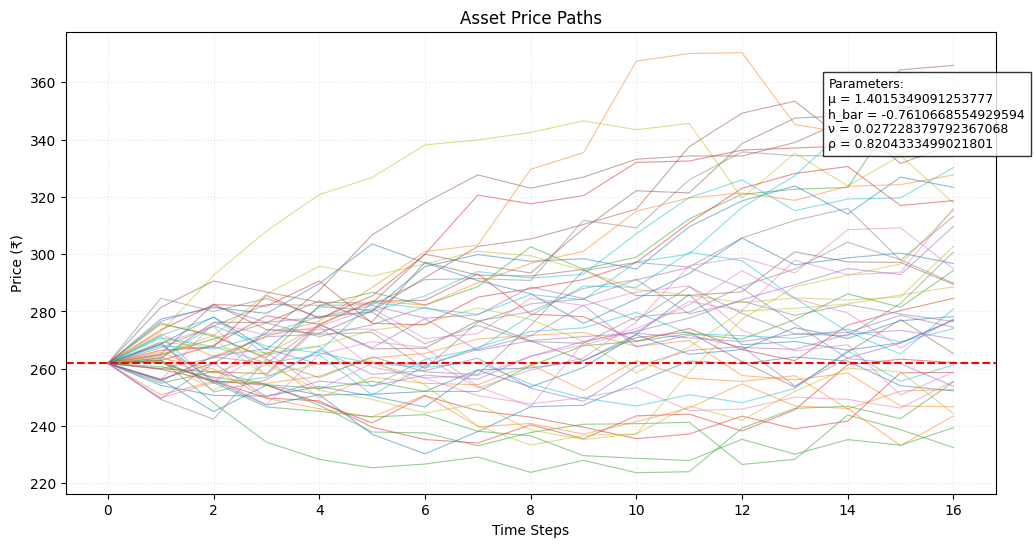

In [200]:
import numpy as np
import matplotlib.pyplot as plt

h=np.zeros(n+1)

def simulate_asset_price_path(S0=S0, mu=μ, h_bar=h_bar, h0=h0,
                            nu=ν, rho=ρ, n=n):
    """
    Simulates asset paths using YOUR EXACT MODEL:
    s += μ*dt + exp(h)*sqrt(dt)*ξ
    h = (1-ρ)*h_bar + ρ*h + ν*sqrt(dt)*η
    """

    n=n
    dt = 1/252
    s = np.zeros(n + 1)
    h = np.zeros(n + 1)
    s[0] = np.log(S0)  # Working in log space
    h[0] = h0

    for t in range(1, n+1):
        # Generate correlated random shocks
        ξ = np.random.randn()
        η = np.random.randn()
        
        # Update volatility process (YOUR EQUATION)
        h[t] = (1 - rho) * h_bar + rho * h[t-1] + nu * np.sqrt(dt) * η
        
        # Update log-price process (YOUR EQUATION)
        s[t] = s[t-1] + mu * dt + np.exp(h[t-1]) * np.sqrt(dt) * ξ
    
    return np.exp(s)  # Convert back to price space

# Chart settings
plt.figure(figsize=(12, 6))
plt.title("Asset Price Paths")

# Simulate and plot 50 paths
for _ in range(50):
    path = simulate_asset_price_path()
    plt.plot(path, alpha=0.5, linewidth=0.8)

# Add current price line (red dashed)
plt.axhline(S0, color='red', linestyle='--', linewidth=1.5, label=f'Current Price: ₹{S0:.2f}')
plt.xlabel("Time Steps", fontsize=10)
plt.ylabel("Price (₹)", fontsize=10)
plt.grid(True, linestyle=':', alpha=0.3)

# Add parameter box
param_text = (f"Parameters:\n"
              f"μ = {μ}\n"
              f"h_bar = {h_bar}\n"
              f"ν = {ν}\n"
              f"ρ = {ρ}")
plt.text(0.82, 0.75, param_text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8), fontsize=9)

plt.show()



### Computing Option Prices

In [ ]:
# Note that in option pricing, we have used mu=risk_free_rate for risk neutral pricing

def compute_option_prices(β=β,
                       μ=risk_free_rate,
                       S0=S0,
                       h0=h0,
                       h_bar=h_bar,
                       K=K,
                       n=n,
                       ρ=ρ,
                       ν=ν,
                       M=M):
# Preallocate arrays for log-price and log-volatility
    s = np.full(M, np.log(S0))
    h = np.full(M, h0)
    dt = 1/252

    # Time loop — but vectorized over all M paths
    for _ in range(n):
        # Generate M normal random variables for both noise terms
        ξ = np.random.randn(M)
        η = np.random.randn(M)

        # Update s and h in-place
        s += μ * dt + np.exp(h) * np.sqrt(dt) * ξ
        h= (1-ρ) * h_bar + ρ * h + ν * np.sqrt(dt)* η

    # Final asset prices
    S_n = np.exp(s)

    # Payoffs
    call_payoffs = np.maximum(S_n - K, 0)
    put_payoffs = np.maximum(K - S_n, 0)

    # Discounted prices and standard errors
    discount = β ** n
    call_price = discount * call_payoffs.mean()
    put_price = discount * put_payoffs.mean()
    
    call_std_err = discount * call_payoffs.std(ddof=1) / np.sqrt(M)
    put_std_err = discount * put_payoffs.std(ddof=1) / np.sqrt(M)

    return (call_price, call_std_err), (put_price, put_std_err)



Final Call Price (M=1M): ₹13.30 ± 0.04
Final Put Price (M=1M): ₹11.45 ± 0.03


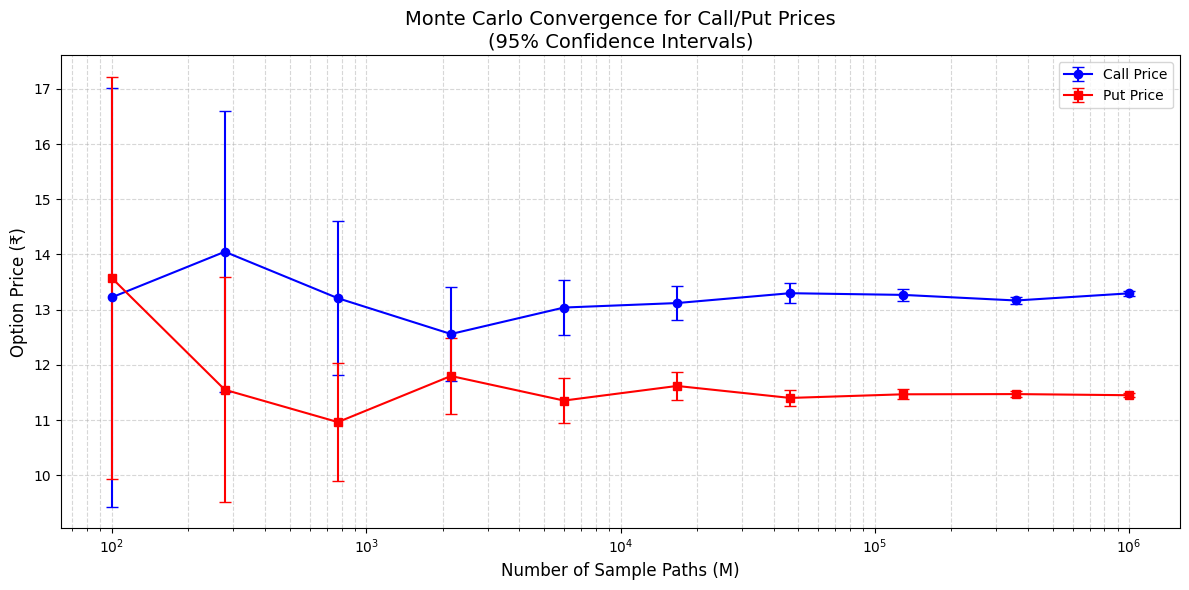

In [226]:
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo sample sizes (from 100 to 1,000,000)
M_values = np.logspace(2, 6, num=10, dtype=int)

# Storage for results
call_means, call_std_errs = [], []
put_means, put_std_errs = [], []

# Run simulations for each M
for M in M_values:
    (call_mean, call_err), (put_mean, put_err) = compute_option_prices(M=M)
    call_means.append(call_mean)
    call_std_errs.append(call_err)
    put_means.append(put_mean)
    put_std_errs.append(put_err)

# Convert to NumPy arrays
call_means = np.array(call_means)
call_std_errs = np.array(call_std_errs)
put_means = np.array(put_means)
put_std_errs = np.array(put_std_errs)

# Plotting
plt.figure(figsize=(12, 6))

# Call prices
plt.errorbar(M_values, call_means, yerr=1.96*call_std_errs, 
             fmt='-o', capsize=4, label='Call Price', color='blue')

# Put prices
plt.errorbar(M_values, put_means, yerr=1.96*put_std_errs, 
             fmt='-s', capsize=4, label='Put Price', color='red')

# Formatting
plt.xscale('log')
plt.xlabel("Number of Sample Paths (M)", fontsize=12)
plt.ylabel("Option Price (₹)", fontsize=12)
plt.title("Monte Carlo Convergence for Call/Put Prices\n(95% Confidence Intervals)", fontsize=14)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()

# Print final estimates
print(f"Final Call Price (M=1M): ₹{call_means[-1]:.2f} ± {1.96*call_std_errs[-1]:.2f}")
print(f"Final Put Price (M=1M): ₹{put_means[-1]:.2f} ± {1.96*put_std_errs[-1]:.2f}")

plt.show()

### Comparison with Black Scholes Model

In [253]:
from scipy.stats import norm
import numpy as np

def bs_call_put_price(S0=S0, K=K, T=n/252, r=risk_free_rate, sigma=np.exp(h_bar)):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    
    return call_price, put_price

bs_call_put_price()

(np.float64(12.267500584930687), np.float64(12.315293728067545))